In [1]:
import pandas as pd
import numpy as np
import scipy
from math import sqrt, log
from pylab import *
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
#instanteInicial = datetime.now()

In [4]:
data = pd.read_csv("/Users/Victor/Documents/Tesis/Historical/data.csv")

In [52]:
def ren(data, n): 
    df_rendimientos = pd.DataFrame()
    for i in range(len(data.index)-1):
        df_rendimientos[i+1] = [log(data.loc[i+1][j]/data.loc[i][j]) for j in range(n)]
    df_rendimientos = pd.DataFrame.transpose(df_rendimientos) 
    mu_rendimientos = df_rendimientos.mean()
    Cov = df_rendimientos.cov()
    L = scipy.linalg.cholesky(Cov, lower=True)
    return Cov, L, mu_rendimientos

In [6]:
def muestra(L, m, mu_rendimientos, n):
    must = pd.DataFrame()
    for i in range(m):
        y = np.dot(L,np.array([np.random.normal(0,1) for k in range(n)]))
        must [i+1] = [y[j] + mu_rendimientos[j] for j in range (n)]
    must = pd.DataFrame.transpose(must)
    return must.mean(), must.cov()    

In [7]:
def optimo(cov,r,g0):
    A = pd.DataFrame(2*cov)
    uno = [1 for i in range(len(r))] 
    ag1 = pd.DataFrame.transpose(pd.DataFrame({'col1': r, 'col2':uno}))
    r, n = list(r), len(r)
    for i in range(2):
        r.append(0), uno.append(0)
    ag2 = pd.DataFrame({'col1': r, 'col2': uno})
    ag1.reset_index(drop=True,inplace=True)
    
    A = pd.concat([A,ag1])
    A['%d'%n] = list(ag2['col1'])
    A['%d'%(n+1)] = list(ag2['col2'])
    
    b = [0 for x in range(n)]
    b.extend([g0,1])
    
    z = np.dot(scipy.linalg.inv(A), np.asarray(b))
    z = z[:-2]
    v = np.dot(np.dot(z,cov),z)
    return z, v

In [8]:
def port(m,t,n):
    instanteInicial = datetime.now()
    C, L, mu_rendimientos = ren(data, n)
    r = ['R%d'%i for i in range(1,n+1)]
    w = ['W%d'%i for i in range(1,n+1)]
    d = ['Var']
    R, W = pd.DataFrame(), pd.DataFrame()
    D = []
    for i in range(t):
        mus, cov = muestra(L, m, mu_rendimientos, n)
        pesos, var = optimo(cov,mus,0.05)
        R = pd.concat([R,pd.DataFrame.transpose(pd.DataFrame(mus))], ignore_index=True)
        W = pd.concat([W,pd.DataFrame.transpose(pd.DataFrame(pesos))],ignore_index=True)
        D.append(var)
    R.columns = r
    W.columns = w
    D = pd.DataFrame(D, columns = d)
    P = pd.concat([R,W,D], axis=1)
    tiempo = datetime.now() - instanteInicial # Devuelve un objeto timedelta
    print(tiempo.seconds)
    return P

In [53]:
C,Li,Rm = ren(data,len(data.columns)-2)
wsp,varp = optimo(C,Rm,0.05)

In [55]:
wsp, varp, Rm

(array([ 13.37273944,  66.10362425, -78.47636369]),
 2.130644498667645,
 0    0.000873
 1    0.001254
 2    0.000568
 dtype: float64)

In [86]:
C

,0,1,2
0,0.000354,0.000197,0.000154
1,0.000197,0.000540,0.000206
2,0.000154,0.000206,0.000296


# tres activos

In [65]:
for i in range(0,len(data.columns)-2):    
    P1['VarPorc_R%d'%(i+1)] = ((P1['R%d'%(i+1)]-Rm[i])/Rm[i])* 100
    P1['VarPorc_W%d'%(i+1)] = ((P1['W%d'%(i+1)]-wsp[i])/wsp[i])* 100
P1['VarPorc_Var'] = ((P1['Var']-varp)/varp)* 100

In [66]:
P1.head()

,R1,R2,R3,W1,W2,W3,Var,VarPorc_R1,VarPorc_R2,VarPorc_R3,VarPorc_W1,VarPorc_W2,VarPorc_W3,VarPorc_Var
0,0.000781,0.002851,0.001252,-15.962024,25.776444,-8.814420,0.260651,-10.599366,127.360436,120.468221,-219.362409,-61.006005,-88.768058,-87.766560
1,0.000235,0.001924,0.001132,-32.057240,25.376779,7.680461,0.420456,-73.095167,53.441807,99.343336,-339.720815,-61.610609,-109.786974,-80.266263
2,0.000823,0.000687,0.000238,63.722992,27.727882,-90.450874,2.103053,-5.739660,-45.191898,-58.149021,376.514123,-58.053916,15.258747,-1.295002
3,0.001235,0.000947,0.000027,31.305728,13.210063,-43.515791,0.496451,41.463749,-24.456537,-95.217744,134.101085,-80.016129,-44.549175,-76.699512
4,0.000415,0.000834,0.000318,-19.184330,99.840024,-79.655694,3.543295,-52.523272,-33.498144,-44.051387,-243.458492,51.035628,1.502784,66.301571


In [67]:
P1.to_csv('3assets_sample(1000).csv')

In [17]:
P1 = port(1000,1000,len(data.columns)-2)

617


In [18]:
P1.var()

R1     3.682149e-07
R2     5.637199e-07
R3     3.212428e-07
W1     6.360128e+03
W2     5.199904e+03
W3     8.384159e+03
Var    5.530272e+02
dtype: float64

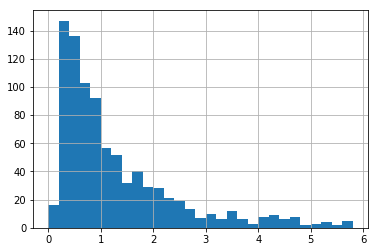

In [89]:
P1['Var'].hist(bins = [i/5 for i in range(0, 30)])

In [9]:
P2 = port(5000,1000, len(data.columns)-2)

3046


In [13]:
P2.var()

R1     6.582856e-08
R2     1.056569e-07
R3     5.601523e-08
W1     6.354983e+03
W2     2.376404e+03
W3     6.047116e+03
Var    4.208702e+02
dtype: float64

In [68]:
for i in range(0,len(data.columns)-2):    
    P2['VarPorc_R%d'%(i+1)] = ((P2['R%d'%(i+1)]-Rm[i])/Rm[i])* 100
    P2['VarPorc_W%d'%(i+1)] = ((P2['W%d'%(i+1)]-wsp[i])/wsp[i])* 100
P2['VarPorc_Var'] = ((P2['Var']-varp)/varp)* 100

In [69]:
P2.head()

,R1,R2,R3,W1,W2,W3,Var,VarPorc_R1,VarPorc_W1,VarPorc_R2,VarPorc_W2,VarPorc_R3,VarPorc_W3,VarPorc_Var
0,0.000658,0.001049,0.000213,16.168496,50.967315,-66.135811,1.364312,-24.597102,20.906386,-16.391030,-22.897850,-62.503468,-15.725184,-35.967167
1,0.001028,0.001156,0.000591,42.646044,54.518341,-96.164385,2.421061,17.738310,218.902828,-7.842382,-17.525943,4.072940,22.539298,13.630462
2,0.001156,0.001372,0.000674,31.952770,48.647148,-79.599918,1.781331,32.349612,138.939598,9.367903,-26.407744,18.648380,1.431711,-16.394721
3,0.000626,0.001343,0.000619,-24.943177,68.512352,-42.569175,1.718262,-28.301475,-286.522565,7.056798,3.643866,9.058262,-45.755419,-19.354829
4,0.000822,0.001039,0.000394,32.389116,55.338753,-86.727869,2.179296,-5.829264,142.202550,-17.118546,-16.284842,-30.677375,10.514638,2.283407


In [70]:
P2.to_csv('3assets_sample(5000).csv')

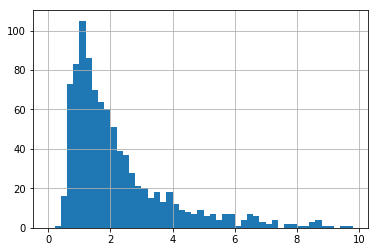

In [43]:
P2['Var'].hist(bins = [i/5 for i in range(0, 50)])

In [19]:
P3 = port(10000,1000, len(data.columns)-2)

8727


In [20]:
P3.var()

R1     3.776234e-08
R2     5.621948e-08
R3     3.084723e-08
W1     1.139085e+03
W2     1.028443e+03
W3     1.306641e+03
Var    1.714613e+01
dtype: float64

In [71]:
for i in range(0,len(data.columns)-2):    
    P3['VarPorc_R%d'%(i+1)] = ((P3['R%d'%(i+1)]-Rm[i])/Rm[i])* 100
    P3['VarPorc_W%d'%(i+1)] = ((P3['W%d'%(i+1)]-wsp[i])/wsp[i])* 100
P3['VarPorc_Var'] = ((P3['Var']-varp)/varp)* 100

In [72]:
P3.head()

,R1,R2,R3,W1,W2,W3,Var,VarPorc_R1,VarPorc_W1,VarPorc_R2,VarPorc_W2,VarPorc_R3,VarPorc_W3,VarPorc_Var
0,0.000699,0.001376,0.000552,-11.645222,62.082247,-49.437025,1.499587,-19.900658,-187.081795,9.713352,-6.083445,-2.867273,-37.003930,-29.618156
1,0.000724,0.001781,0.000594,-11.101908,42.813048,-30.711140,0.685107,-17.057644,-183.018947,42.050860,-35.233434,4.505114,-60.865745,-67.845071
2,0.000790,0.001388,0.000546,-0.960481,59.034351,-57.073870,1.469490,-9.478971,-107.182383,10.643450,-10.694229,-3.896553,-27.272535,-31.030725
3,0.001179,0.001365,0.000739,36.443210,53.096599,-88.539809,2.089164,35.066017,172.518659,8.806903,-19.676721,30.095862,12.823537,-1.946849
4,0.000921,0.001245,0.000662,18.373565,76.410323,-93.783888,2.922182,5.517920,37.395668,-0.688194,15.591730,16.561021,19.505904,37.150154


In [73]:
P3.to_csv('3assets_sample(10000).csv')

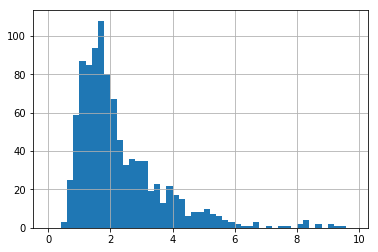

In [44]:
P3['Var'].hist(bins = [i/5 for i in range(0, 50)])

In [21]:
P4 = port(15000,1000, len(data.columns)-2)

14967


In [22]:
P4.var()

R1     2.290710e-08
R2     3.823091e-08
R3     1.888785e-08
W1     5.811103e+02
W2     4.106118e+02
W3     7.652009e+02
Var    3.372607e+00
dtype: float64

In [74]:
for i in range(0,len(data.columns)-2):    
    P4['VarPorc_R%d'%(i+1)] = ((P4['R%d'%(i+1)]-Rm[i])/Rm[i])* 100
    P4['VarPorc_W%d'%(i+1)] = ((P4['W%d'%(i+1)]-wsp[i])/wsp[i])* 100
P4['VarPorc_Var'] = ((P4['Var']-varp)/varp)* 100

In [75]:
P4.head()

,R1,R2,R3,W1,W2,W3,Var,VarPorc_R1,VarPorc_W1,VarPorc_R2,VarPorc_W2,VarPorc_R3,VarPorc_W3,VarPorc_Var
0,0.001034,0.001192,0.000813,46.376430,102.566299,-147.942730,6.349305,18.441900,246.798280,-4.938532,55.159873,43.075900,88.518839,197.999264
1,0.000940,0.001173,0.000543,31.084642,58.805528,-88.890170,2.252759,7.718191,132.447826,-6.443378,-11.040388,-4.477531,13.269990,5.731360
2,0.000884,0.001662,0.000710,-8.724401,53.357443,-43.633041,1.096382,1.247255,-165.240196,32.515605,-19.282122,24.922829,-44.399766,-48.542249
3,0.001210,0.001437,0.000726,29.844372,49.019016,-77.863388,1.692886,38.608041,123.173213,14.559925,-25.845192,27.842840,-0.781096,-20.545847
4,0.001091,0.001308,0.000848,30.270239,90.794928,-120.065167,4.441428,24.981205,126.357803,4.317180,37.352421,49.285233,52.995324,108.454687


In [76]:
P4.to_csv('3assets_sample(15000).csv')

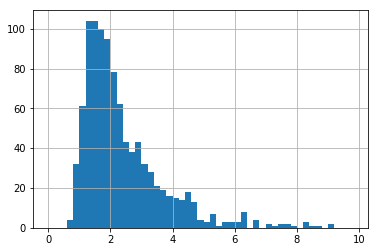

In [45]:
P4['Var'].hist(bins = [i/5 for i in range(0, 50)])

In [23]:
P6 = port(20000,1000, len(data.columns)-2)

25761


In [77]:
for i in range(0,len(data.columns)-2):    
    P6['VarPorc_R%d'%(i+1)] = ((P6['R%d'%(i+1)]-Rm[i])/Rm[i])* 100
    P6['VarPorc_W%d'%(i+1)] = ((P6['W%d'%(i+1)]-wsp[i])/wsp[i])* 100
P6['VarPorc_Var'] = ((P6['Var']-varp)/varp)* 100

In [78]:
P6.head()

,R1,R2,R3,W1,W2,W3,Var,VarPorc_R1,VarPorc_W1,VarPorc_R2,VarPorc_W2,VarPorc_R3,VarPorc_W3,VarPorc_Var
0,0.000908,0.001244,0.000733,5.314791,94.683622,-98.998414,3.886446,3.965672,-60.256527,-0.840580,43.235146,29.049113,26.150613,82.407040
1,0.001048,0.001614,0.000540,10.246810,41.207265,-50.454075,0.856011,20.022446,-23.375388,28.715185,-37.662623,-4.897152,-35.707935,-59.823859
2,0.000774,0.001414,0.000564,-4.068370,59.147977,-54.079606,1.401069,-11.301807,-130.422862,12.761542,-10.522339,-0.732905,-31.088032,-34.242008
3,0.000935,0.001032,0.000522,50.747617,55.843729,-105.591346,2.954048,7.108146,279.485571,-17.729813,-15.520927,-8.176991,34.551782,38.645755
4,0.000738,0.001194,0.000362,12.014189,54.202426,-65.216616,1.460230,-15.436315,-10.159100,-4.785534,-18.003851,-36.311671,-16.896486,-31.465320


In [79]:
P6.to_csv('3assets_sample(20000).csv')

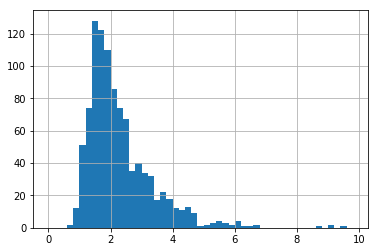

In [46]:
P6['Var'].hist(bins = [i/5 for i in range(0, 50)])

In [82]:
print(np.percentile(P1['Var'],95)-np.percentile(P1['Var'],5))
print(np.percentile(P2['Var'],95)-np.percentile(P2['Var'],5))
print(np.percentile(P3['Var'],95)-np.percentile(P3['Var'],5))
print(np.percentile(P6['Var'],95)-np.percentile(P6['Var'],5))

13.878371964195152
10.921494282500381
4.8113897787235675
3.286628986041122


# cinco activos

In [10]:
P5 = port(5000,1000, len(data.columns))

3205


In [14]:
P5.var()

R1     7.050165e-08
R2     1.132705e-07
R3     5.856436e-08
R4     2.271713e-07
R5     6.112664e-08
W1     5.098716e+02
W2     3.261699e+02
W3     5.474915e+02
W4     1.251505e+02
W5     5.873481e+02
Var    1.346018e+00
dtype: float64

In [83]:
for i in range(0,len(data.columns)-2):    
    P5['VarPorc_R%d'%(i+1)] = ((P5['R%d'%(i+1)]-Rm[i])/Rm[i])* 100
    P5['VarPorc_W%d'%(i+1)] = ((P5['W%d'%(i+1)]-wsp[i])/wsp[i])* 100
P5['VarPorc_Var'] = ((P5['Var']-varp)/varp)* 100

In [84]:
P5.head()

,R1,R2,R3,R4,R5,W1,W2,W3,W4,W5,Var,VarPorc_R1,VarPorc_W1,VarPorc_R2,VarPorc_W2,VarPorc_R3,VarPorc_W3,VarPorc_Var
0,0.000783,0.000728,0.000675,0.001262,0.000610,47.904999,-7.073622,-18.708532,66.147124,-87.269969,5.422300,-10.377147,258.228764,-41.964335,-110.700808,18.819519,-76.160297,154.491067
1,0.000912,0.001248,0.000640,0.001659,0.000800,10.841639,41.329727,-53.849919,24.265010,-21.586456,1.699466,4.459702,-18.927317,-0.510259,-37.477366,12.623974,-31.380716,-20.236995
2,0.001178,0.001204,0.000776,0.002228,0.000733,23.565894,11.013014,-20.922612,23.060854,-35.717150,0.906822,34.933723,76.223387,-3.974493,-83.339772,36.611680,-73.338963,-57.439066
3,0.000748,0.001197,-0.000062,0.001784,0.000395,12.858824,20.225368,-32.547313,10.063850,-9.600729,0.454667,-14.375672,-3.843010,-4.577281,-69.403542,-110.941176,-58.525967,-78.660590
4,0.000999,0.001047,0.000849,0.001626,0.000605,30.081203,19.066746,0.830981,28.318077,-77.297008,1.744735,14.451322,124.944213,-16.533357,-71.156278,49.441153,-101.058894,-18.112359


In [85]:
P5.to_csv('5assets_sample(5000).csv')

In [2]:
#P8 = port(10000,1000,len(data.columns))

In [ ]:
P9 = port(15000,1000,len(data.columns))

In [12]:
P7 = port(5000,10000,len(data.columns))

34774


In [15]:
P7.var()

R1     7.043806e-08
R2     1.086600e-07
R3     5.727907e-08
R4     2.382264e-07
R5     5.893863e-08
W1     4.618134e+02
W2     3.428647e+02
W3     5.272165e+02
W4     1.083529e+02
W5     6.373512e+02
Var    1.301472e+00
dtype: float64